In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install anesthetic
import os
os.chdir("/content/drive/MyDrive/project")

In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from np_utils import simple_data, curved_data
from torch_utils import TrainUtil, rotation_test
from anesthetic.plot import kde_contour_plot_2d, kde_plot_1d
from tension_net import TensionNet, TensionNet1, TensionNet2
from tension_quantify import BayesFactor, SuspiciousnessKLDiv

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
train_utils = []
distances = [0.5, 1, 3, 6, 8, 10, 11]
for dist in distances:
    X0, X1, X_prior = simple_data(dims=2, distance=dist, fixed=True)
    tension_R = TensionNet2(2)
    criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                            n_prior_bins=50)
    optimizer = optim.SGD(tension_R.parameters(), lr=0.0005)

    train_util_R = TrainUtil(tension_R, optimizer, criterion, device,  
                            animation=False)
    losses_R = train_util_R.train(X0, X1, X_prior, n_iter=200)
    train_utils.append(train_util_R)

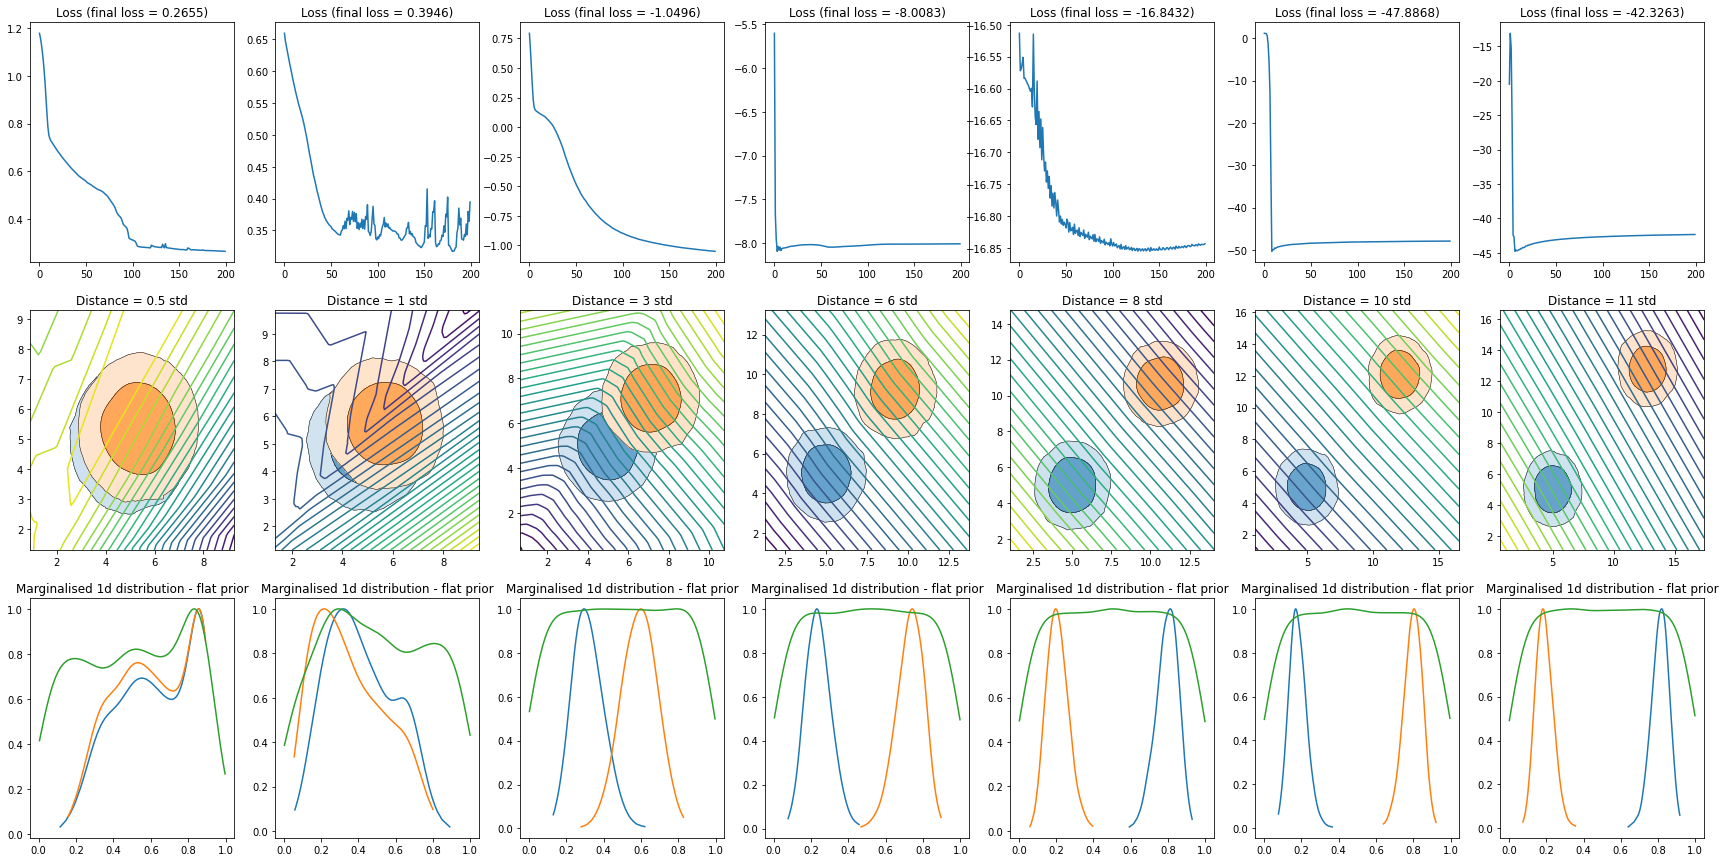

In [26]:
fig, axs = plt.subplots(3, 7, figsize=(30, 15))

for i, util in enumerate(train_utils):
    util.plot_loss(axs[0, i])
    util.visualise_coordinate(axs[1, i])
    util.plot_marginalised_dists(axs[2, i], flat_prior=True)
    axs[1, i].set_title(f"Distance = {distances[i]} std")

In [27]:
distances = [0.5, 1, 2, 3, 4]
thetas = {}
losses = {}
X0s = {}
X1s = {}
X_priors = {}
X0, X1, X_prior = simple_data(dims=2, distance=4, fixed=True)
for dist in distances:
    # X0, X1, _ = simple_data(dims=2, distance=dist, fixed=True)
    X1_new = X1 - (np.sqrt(2) * 2) + dist / np.sqrt(2)
    X0s[dist] = X0
    X1s[dist] = X1_new
    X_priors[dist] = X_prior

    net = TensionNet(2)
    criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100,
                            n_prior_bins=50)
    thetas[dist], losses[dist], _ = rotation_test(net, criterion, device, X0,
                                               X1_new, X_prior)
    

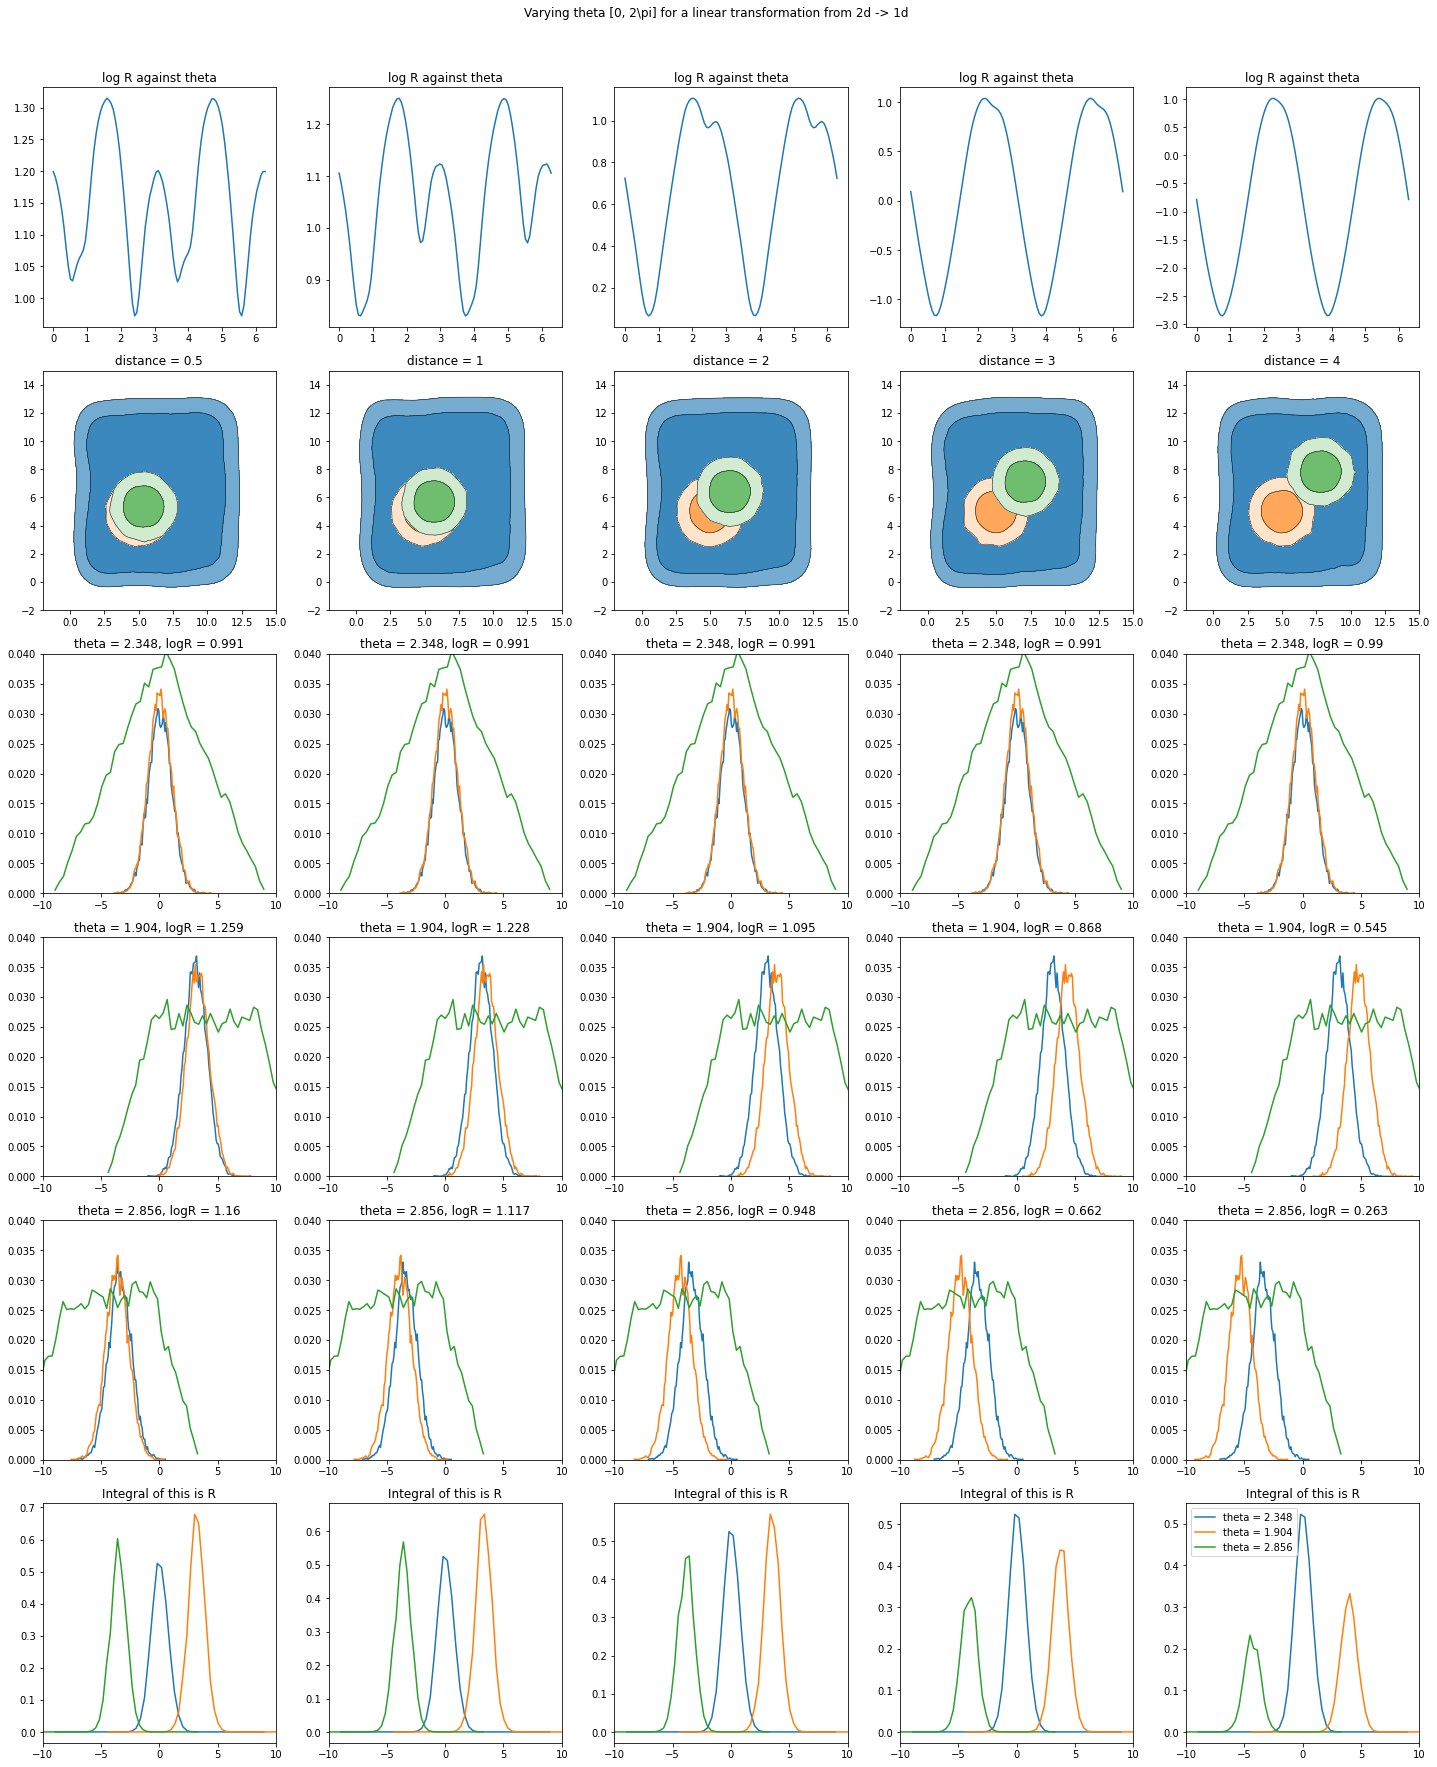

In [31]:
fig, axs = plt.subplots(6, 5, figsize=(20, 25))
fig.suptitle("Varying theta [0, 2\pi] for a linear transformation from 2d -> 1d")
criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100,
                    n_prior_bins=50, extra=True)

for i, dist in enumerate(distances):
    axs[0, i].set_title(f"log R against theta")
    axs[0, i].plot(thetas[dist], losses[dist])
    kde_contour_plot_2d(axs[1, i], X_priors[dist][:, 0], X_priors[dist][:, 1])
    kde_contour_plot_2d(axs[1, i], X0s[dist][:, 0], X0s[dist][:, 1])
    kde_contour_plot_2d(axs[1, i], X1s[dist][:, 0], X1s[dist][:, 1])
    axs[1, i].set_xlim([-2, 15])
    axs[1, i].set_ylim([-2, 15])
    axs[1, i].set_title(f"distance = {dist}")
    
    theta = thetas[dist][37]
    weight = torch.tensor([[np.cos(theta), np.sin(theta)]]).to(device)
    tension_net = TensionNet(2).to(device)
    tension_net.state_dict()["linear.weight"].copy_(weight)
    tension_net.state_dict()["linear.bias"].copy_(torch.tensor([0]).to(device))
    X0_1d = tension_net(torch.tensor(X0s[dist]).to(device).float())
    X1_1d = tension_net(torch.tensor(X1s[dist]).to(device).float())
    X_prior_1d = tension_net(torch.tensor(X_priors[dist]).to(device).float())
    loss, wA, bA, wB, bB, cwA, cwB, wp, bp = criterion(X0_1d, X1_1d, X_prior_1d)

    X0_1d = X0_1d.squeeze().cpu().detach().numpy()
    X1_1d = X1_1d.squeeze().cpu().detach().numpy()
    X_prior_1d = X_prior_1d.squeeze().cpu().detach().numpy()

    axs[2, i].plot(bA.cpu().detach().numpy(), wA.cpu().detach().numpy())
    axs[2, i].plot(bB.cpu().detach().numpy(), wB.cpu().detach().numpy())
    axs[2, i].plot(bp.cpu().detach().numpy(), wp.cpu().detach().numpy())
    axs[2, i].set_title(f"theta = {round(thetas[dist][37], 3)}, "\
                        f"logR = {round(losses[dist][37], 3)}")
    axs[2, i].set_xlim([-10, 10])
    axs[2, i].set_ylim([0, 0.04])
    
    axs[5, i].plot(bp.cpu().detach().numpy(), 
                   (cwA * cwB / wp).cpu().detach().numpy(),
                   label=f"theta = {round(thetas[dist][37], 3)}")



    theta = thetas[dist][30]
    weight = torch.tensor([[np.cos(theta), np.sin(theta)]]).to(device)
    tension_net = TensionNet(2).to(device)
    tension_net.state_dict()["linear.weight"].copy_(weight)
    tension_net.state_dict()["linear.bias"].copy_(torch.tensor([0]).to(device))
    X0_1d = tension_net(torch.tensor(X0s[dist]).to(device).float())
    X1_1d = tension_net(torch.tensor(X1s[dist]).to(device).float())
    X_prior_1d = tension_net(torch.tensor(X_priors[dist]).to(device).float())
    loss, wA, bA, wB, bB, cwA, cwB, wp, bp = criterion(X0_1d, X1_1d, X_prior_1d)

    X0_1d = X0_1d.squeeze().cpu().detach().numpy()
    X1_1d = X1_1d.squeeze().cpu().detach().numpy()
    X_prior_1d = X_prior_1d.squeeze().cpu().detach().numpy()

    axs[3, i].plot(bA.cpu().detach().numpy(), wA.cpu().detach().numpy())
    axs[3, i].plot(bB.cpu().detach().numpy(), wB.cpu().detach().numpy())
    axs[3, i].plot(bp.cpu().detach().numpy(), wp.cpu().detach().numpy())
    axs[3, i].set_title(f"theta = {round(thetas[dist][30], 3)}, "\
                        f"logR = {round(losses[dist][30], 3)}")
    axs[3, i].set_xlim([-10, 10])
    axs[3, i].set_ylim([0, 0.04])
    
    axs[5, i].plot(bp.cpu().detach().numpy(), 
                   (cwA * cwB / wp).cpu().detach().numpy(),
                   label=f"theta = {round(thetas[dist][30], 3)}")


    theta = thetas[dist][45]
    weight = torch.tensor([[np.cos(theta), np.sin(theta)]]).to(device)
    tension_net = TensionNet(2).to(device)
    tension_net.state_dict()["linear.weight"].copy_(weight)
    tension_net.state_dict()["linear.bias"].copy_(torch.tensor([0]).to(device))
    X0_1d = tension_net(torch.tensor(X0s[dist]).to(device).float())
    X1_1d = tension_net(torch.tensor(X1s[dist]).to(device).float())
    X_prior_1d = tension_net(torch.tensor(X_priors[dist]).to(device).float())
    loss, wA, bA, wB, bB, cwA, cwB, wp, bp = criterion(X0_1d, X1_1d, X_prior_1d)

    X0_1d = X0_1d.squeeze().cpu().detach().numpy()
    X1_1d = X1_1d.squeeze().cpu().detach().numpy()
    X_prior_1d = X_prior_1d.squeeze().cpu().detach().numpy()

    axs[4, i].plot(bA.cpu().detach().numpy(), wA.cpu().detach().numpy())
    axs[4, i].plot(bB.cpu().detach().numpy(), wB.cpu().detach().numpy())
    axs[4, i].plot(bp.cpu().detach().numpy(), wp.cpu().detach().numpy())
    axs[4, i].set_title(f"theta = {round(thetas[dist][45], 3)}, "\
                        f"logR = {round(losses[dist][45], 3)}")
    axs[4, i].set_xlim([-10, 10])
    axs[4, i].set_ylim([0, 0.04])

    axs[5, i].plot(bp.cpu().detach().numpy(), 
                   (cwA * cwB / wp).cpu().detach().numpy(),
                   label=f"theta = {round(thetas[dist][45], 3)}")
    
    axs[5, i].set_xlim([-10, 10])
    axs[5, i].set_title("Integral of this is R")

axs[5, 4].legend()
fig.tight_layout(rect=[0, 0, 1, 0.95])


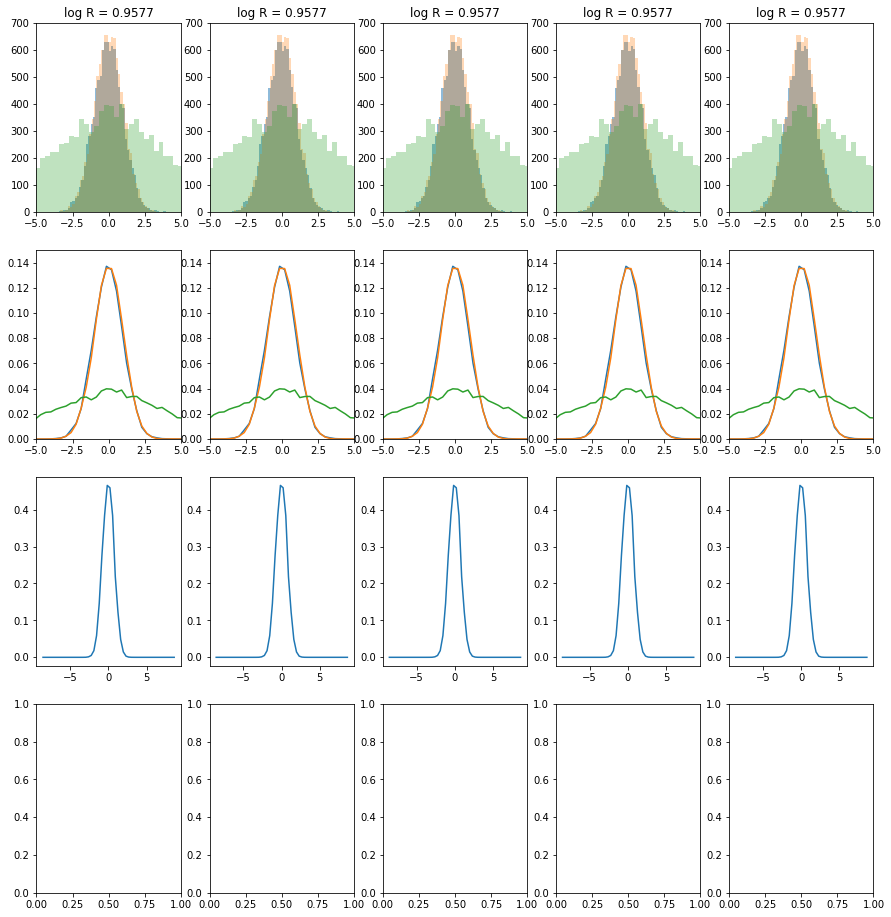

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(15, 16))
distances = [0.5, 1, 2, 3, 4]
# _, _, X_prior = simple_data(dims=2, distance=4, fixed=True)

for i, dist in enumerate(distances):
    # X0, X1, _ = simple_data(dims=2, distance=dist, fixed=True)
    X1_new = X1 - (np.sqrt(2) * 2) + dist / np.sqrt(2)
    theta = 3 * np.pi / 4
    weight = torch.tensor([[np.cos(theta), np.sin(theta)]]).to(device)
    tension_net = TensionNet(2).to(device)
    tension_net.state_dict()["linear.weight"].copy_(weight)
    tension_net.state_dict()["linear.bias"].copy_(torch.tensor([0]).to(device))
    X0_1d = tension_net(torch.tensor(X0).to(device).float())
    X1_1d = tension_net(torch.tensor(X1_new).to(device).float())
    X_prior_1d = tension_net(torch.tensor(X_prior).to(device).float())

    criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100,
                        n_prior_bins=50, extra=True)
    loss, wA, bA, wB, bB, cwA, cwB, wp, bp = criterion(X0_1d, X1_1d, X_prior_1d)
    
    axs[0, i].hist(X0_1d.cpu().detach().numpy(), bins=50, alpha=0.5)
    axs[0, i].hist(X1_1d.cpu().detach().numpy(), bins=50, alpha=0.3)
    axs[0, i].hist(X_prior_1d.cpu().detach().numpy(), bins=50, alpha=0.3)
    axs[0, i].set_xlim([-5, 5])
    axs[0, i].set_ylim([0, 700])
    axs[0, i].set_title(f"log R = {round(loss.item(), 4)}")

    axs[1, i].plot(bp.cpu().detach().numpy(), cwA.cpu().detach().numpy())
    axs[1, i].plot(bp.cpu().detach().numpy(), cwB.cpu().detach().numpy())
    axs[1, i].plot(bp.cpu().detach().numpy(), wp.cpu().detach().numpy())
    axs[1, i].set_xlim([-5, 5])
    axs[1, i].set_ylim([0, 0.15])

    axs[2, i].plot(bp.cpu().detach().numpy(), (cwA * cwB / wp).cpu().detach().numpy())
    # axs[1, i].plot(bp.cpu().detach().numpy(), cwB.cpu().detach().numpy())
    # axs[1, i].plot(bp.cpu().detach().numpy(), wp.cpu().detach().numpy())
    axs[1, i].set_xlim([-5, 5])
    axs[1, i].set_ylim([0, 0.15])

In [ ]:
n_bins = [100, 300, 500, 800, 1000]
thetas = {}
losses = {}
for n_bin in n_bins:
    X0, X1, X_prior = simple_data(dims=2, distance=1, fixed=True)
    X0s[n_bin] = X0
    X1s[n_bin] = X1
    X_priors[n_bin] = X_prior

    net = TensionNet(2)
    criterion = BayesFactor(hist_type="gaussian", hist_param=1,
                            n_dist_bins=n_bin, n_prior_bins=50)

    thetas[n_bin], losses[n_bin] = rotation_test(net, criterion, device, X0, X1,
                                                 X_prior)

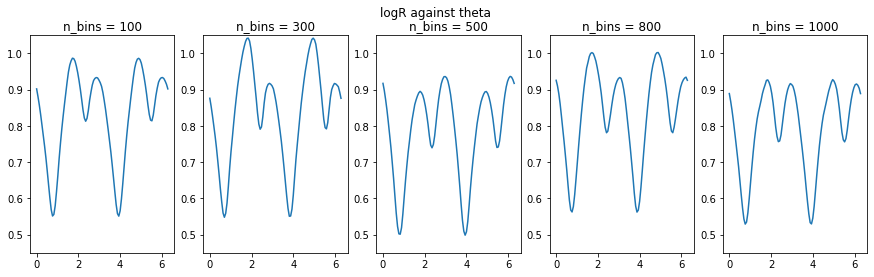

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
fig.suptitle("logR against theta")

for i, n_bin in enumerate(n_bins):
    axs[i].set_title(f"n_bins = {n_bin}")
    axs[i].plot(thetas[n_bin], losses[n_bin])
    axs[i].set_ylim([0.45, 1.05])

In [ ]:
n_bins = [100, 300, 500, 800, 1000]
thetas = {}
losses = {}
for n_bin in n_bins:
    X0, X1, X_prior = simple_data(dims=2, distance=1, fixed=True)
    X0s[n_bin] = X0
    X1s[n_bin] = X1
    X_priors[n_bin] = X_prior

    net = TensionNet(2)
    criterion = BayesFactor(hist_type="gaussian", hist_param=1, 
                            n_dist_bins=1000, n_prior_bins=n_bin)
    thetas[n_bin], losses[n_bin] = rotation_test(net, criterion, device, X0, X1,
                                                 X_prior)

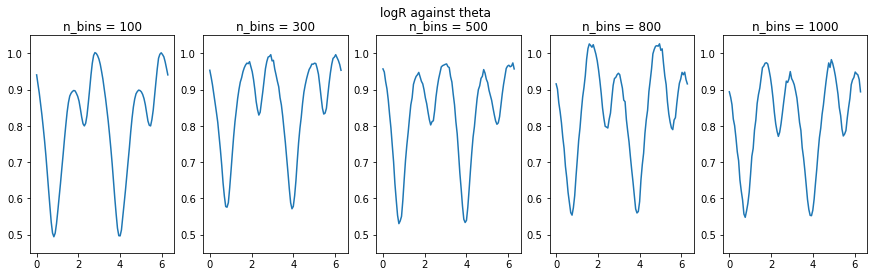

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
fig.suptitle("logR against theta")

for i, n_bin in enumerate(n_bins):
    axs[i].set_title(f"n_bins = {n_bin}")
    axs[i].plot(thetas[n_bin], losses[n_bin])
    axs[i].set_ylim([0.45, 1.05])